In [58]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import logging
import pickle

import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles, MolToSmiles
from sklearn.metrics import pairwise_distances
from torch.utils.data import Dataset

from rxnmapper import RXNMapper
rxnmapper = RXNMapper()
with open('48 reaction reactant weight.npy', 'rb') as f:
    weight = np.load(f,allow_pickle=True)
weight = np.array(weight)
print(weight.shape)


Some weights of the model checkpoint at /users/PCON0041/xiaohu/anaconda3/envs/rxnfp/lib/python3.6/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(86, 47, 1)


In [59]:
result = np.array([0.6982, 0.8334, 0.8653, 0.8135, 0.9059, 0.6554, 0.5917, 0.7746, 0.8378,
        0.6479, 0.8792, 0.7536, 0.6135, 0.8169, 0.7169, 0.6844, 0.6687, 0.6784,
        0.7460, 0.8786, 0.7611, 0.7433, 0.8120, 0.7234, 0.5389, 0.8179, 0.8796,
        0.7633, 0.7540, 0.9082, 0.7121, 0.6613, 0.7028, 0.7338, 0.7804, 0.6306,
        0.5630, 0.8154, 0.7950, 0.7026, 0.6223, 0.7115, 0.6671, 0.6725, 0.7794,
        0.8490, 0.7831, 0.7058]) 
target = np.array([0.0000, 0.2110, 0.2600, 0.3300, 0.4000, 0.5300, 0.5500, 0.5400, 0.9100,
        0.9100, 0.7800, 0.7300, 0.6280, 0.0000, 0.1300, 0.2000, 0.3500, 0.4900,
        0.5700, 0.4700, 0.5200, 0.4600, 0.9900, 0.9200, 0.6100, 0.8400, 0.9900,
        0.7500, 0.0000, 0.0000, 0.1200, 0.2000, 0.3000, 0.1800, 0.4500, 0.5300,
        0.3500, 0.6000, 0.5200, 0.9600, 0.7100, 0.9900, 0.8400, 0.8200, 0.8000,
        0.2600, 0.5800, 0.1400])

In [60]:
r_list = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/sample/sample_test_CJ_processed_final.csv')['reactants'].values
r_index_list = []
ri_list = []
amount = 0
for i in range(len(r_list)):
    r = r_list[i].split('.')
    #print(r)
    r_index = [i + amount for i in range(0, len(r))] 
    #print(r_index)
    amount += len(r)
    r_index_list.append(r_index)
    ri_list.append(r)
print(len(r_index_list))
mr_list = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/sample/sample_test_CJ_processed_final.csv')['reactants_mapped'].values
#print(mr_list)
mr_index_list = []
mri_list = []
amount = 0
for i in range(len(mr_list)):
    #print('!!')
    mr = mr_list[i].split('.')
    #print(mr)
    mr_index = [i + amount for i in range(0, len(mr))] 
    #print(mr_index)
    amount += len(mr)
    mr_index_list.append(mr_index)
    mri_list.append(mr)

p_list = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/sample/sample_test_CJ_processed_final.csv')['products'].values
p_index_list = []
pi_list = []
amount = 0
for i in range(len(p_list)):
    p = p_list[i].split('.')
    #print(p)
    p_index = [i + amount for i in range(1, len(p)+1)] 
    #print(p_index)
    amount += len(p)
    p_index_list.append(p_index)
    pi_list.append(p)

mp_list = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/sample/sample_test_CJ_processed_final.csv')['products_mapped'].values
mp_index_list = []
mpi_list = []
amount = 0
for i in range(len(mp_list)):
    mp = mp_list[i].split('.')
    #print(mp)
    mp_index = [i + amount for i in range(1, len(mp)+1)] 
    #print(mp_index)
    amount += len(mp)
    mp_index_list.append(mp_index)
    mpi_list.append(mp)

48


In [61]:
def get_mol(r):
    mol = MolFromSmiles(r)
    #mol = Chem.AddHs(mol)
    #AllChem.EmbedMolecule(mol, maxAttempts=5000)
    #AllChem.UFFOptimizeMolecule(mol)
    #mol = Chem.RemoveHs(mol)
    mol = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=True)
    updated_smi = MolToSmiles(mol)
    return mol, updated_smi

In [79]:
idx = 25
print(r_index_list[idx])
print(result[idx],target[idx])

[48, 49]
0.8179 0.84


In [105]:
r1_index = r_index_list[idx][0] 
print(r1_index)
r1_name = ri_list[idx][0]
mapped_r1 = mri_list[idx][0]
print(mapped_r1)
r1_w = weight[r1_index] * 0.8
#print(r1_w)

48
Cl[S:2](=[O:1])(=[O:3])[c:4]1[cH:5][cH:6][cH:7][cH:8][cH:9]1


In [93]:
r1_w

array([[0.86121],
       [0.16821],
       [0.85905],
       [0.18774],
       [0.18774],
       [0.15714],
       [0.11205],
       [0.08208],
       [0.07632],
       [0.08208],
       [0.11205],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703],
       [0.08703]])

In [104]:
r2_index = r_index_list[idx][1] 
print(r2_index)
r2_name = ri_list[idx][1]
mapped_r2 = mri_list[idx][1]
print(mapped_r2)
r2_w = weight[r2_index] * 0.8

49
[nH:10]1[cH:11][cH:12][c:13]2[cH:14][cH:15][cH:16][cH:17][c:18]12


In [415]:
r3_index = r_index_list[idx][2] 
print(r3_index)
r3_name = ri_list[idx][2]
mapped_r3 = mri_list[idx][2]
print(mapped_r3)
r3_w = weight[r3_index]

85
[OH:4][CH2:5][CH2:6][O:7][CH2:8][CH2:9][O:10][CH2:11][CH2:12][O:13][CH2:14][CH2:15][O:16][CH2:17][CH2:18][OH:19]


In [95]:
p1_name = p_list[idx]
mapped_p1 = mp_list[idx]
print(mapped_p1)

[O:1]=[S:2](=[O:3])([c:4]1[cH:5][cH:6][cH:7][cH:8][cH:9]1)[n:10]1[cH:11][cH:12][c:13]2[cH:14][cH:15][cH:16][cH:17][c:18]12


In [65]:
# provide SMILES of reactants and products separated by >>
print(r1_name +  '>>'  + p1_name)
example_reaction = get_mol(r1_name)[1] + '>>' + get_mol(p1_name)[1]

COc1ccc(cc1)\N=C(/C)c1ccccc1>>COc1ccc(NC(C)c2ccccc2)cc1


In [96]:
# provide SMILES of reactants and products separated by >>
print(r1_name + '.' + r2_name + '>>'  + p1_name)
example_reaction = get_mol(r1_name)[1] + '.' + get_mol(r2_name)[1] + '>>' + get_mol(p1_name)[1]

c1cc2ccccc2[nH]1.ClS(=O)(=O)c1ccccc1>>O=S(=O)(c1ccccc1)n1ccc2ccccc12


In [418]:
print(r1_name + '.' + r2_name + '.' + r3_name + '>>'  + p1_name)
example_reaction = get_mol(r1_name)[1] + '.' + get_mol(r2_name)[1] + '.' + get_mol(r3_name)[1] + '>>' + get_mol(p1_name)[1]

BrCC#C.BrCC#C.OCCOCCOCCOCCOCCO>>C#CCOCCOCCOCCOCCOCCOCC#C


Cl[S:2](=[O:1])(=[O:3])[c:4]1[cH:5][cH:6][cH:7][cH:8][cH:9]1.[nH:10]1[cH:11][cH:12][c:13]2[cH:14][cH:15][cH:16][cH:17][c:18]12>>[O:1]=[S:2](=[O:3])([c:4]1[cH:5][cH:6][cH:7][cH:8][cH:9]1)[n:10]1[cH:11][cH:12][c:13]2[cH:14][cH:15][cH:16][cH:17][c:18]12


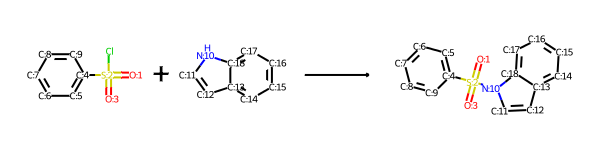

In [97]:
#print(example_reaction)
res = rxnmapper.get_attention_guided_atom_maps([example_reaction])
rxn_smarts = res[0]['mapped_rxn']
print(rxn_smarts)
from rdkit.Chem import rdChemReactions
rxn = rdChemReactions.ReactionFromSmarts(rxn_smarts,useSmiles=True)
#rxn = AllChem.ReactionFromSmarts(rxn_smarts)
rxn


In [106]:
from PIL import Image
from io import BytesIO
def show_reactant_mol(d2d, mol, highlightAtoms, bondhighlights, arads, legend):
    #d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    print(legend)
    d2d.DrawMoleculeWithHighlights(mol,legend, highlightAtoms, bondhighlights, arads, {})
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

def show_product_mol(d2d,mol,legend='',highlightAtoms={}):
    d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    #d2d.DrawMoleculeWithHighlights(r1,legend=legend, highlightAtoms, bondhighlights, arads, {})
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

def show_arrow(d2d):
    #d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    #d2d.DrawMoleculeWithHighlights(r1,legend=legend, highlightAtoms, bondhighlights, arads, {})
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

def show_images(imgs,buffer=15):
    height = 0
    width = 0
    for img in imgs:
        height = max(height,img.height)
        width += img.width
    width += buffer*(len(imgs)-1)
    print(width,height)
    res = Image.new("RGBA",(width,height))
    x = 0
    for img in imgs:
        res.paste(img,(x,0))
        x += img.width + buffer
    return res

In [112]:
imgs = []
img_size = 600
buffer = 15

In [113]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
import rdkit


r1 = get_mol(mapped_r1)[0]
d2d = Draw.MolDraw2DCairo(img_size, img_size)
dopts = d2d.drawOptions()
dopts.minFontSize = 22
dopts.useBWAtomPalette()

cmap = plt.cm.get_cmap('coolwarm')
colors = [tuple(color) for color in cmap(r1_w).squeeze().tolist()]
athighlights = defaultdict(list)
arads = {}
for i, atom in enumerate(r1.GetAtoms()):
    aid = atom.GetIdx()
    athighlights[aid].append(colors[aid + 1])
    arads[aid] = 0.1
print(r1_name)
bondhighlights = defaultdict(list)
imgs.append(show_reactant_mol(d2d,r1,dict(athighlights),dict(bondhighlights),arads,'r1'))
print(imgs)

c1cc2ccccc2[nH]1
r1
[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x600 at 0x2B533A283EB8>]


In [114]:
#imgs = []
r2 = get_mol(mapped_r2)[0]
cmap = plt.cm.get_cmap('coolwarm')
colors = [tuple(color) for color in cmap(r2_w).squeeze().tolist()]
athighlights = defaultdict(list)
arads = {}
for i, atom in enumerate(r2.GetAtoms()):
    aid = atom.GetIdx()
    athighlights[aid].append(colors[aid + 1])
    arads[aid] = 0.1
print(r2_name)
bondhighlights = defaultdict(list)
d2d = Draw.MolDraw2DCairo(img_size,img_size)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
imgs.append(show_reactant_mol(d2d,r2,dict(athighlights),dict(bondhighlights),arads,'r2'))
print(imgs)

ClS(=O)(=O)c1ccccc1
r2
[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x600 at 0x2B533A283EB8>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x600 at 0x2B533A283FD0>]


In [424]:
#imgs = []
r3 = get_mol(mapped_r3)[0]
cmap = plt.cm.get_cmap('coolwarm')
colors = [tuple(color) for color in cmap(r3_w).squeeze().tolist()]
athighlights = defaultdict(list)
arads = {}
for i, atom in enumerate(r3.GetAtoms()):
    aid = atom.GetIdx()
    athighlights[aid].append(colors[aid + 1])
    arads[aid] = 0.1
print(r3_name)
bondhighlights = defaultdict(list)
d2d = Draw.MolDraw2DCairo(img_size,img_size)
dopts = d2d.drawOptions()
imgs.append(show_reactant_mol(d2d,r3,dict(athighlights),dict(bondhighlights),arads,'r3'))
print(imgs)

OCCOCCOCCOCCOCCO
r3
[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x400 at 0x2BA7FB7137F0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x400 at 0x2BA7FB713400>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x400 at 0x2BA7FB7135C0>]


In [116]:
from rdkit import Geometry
#imgs = []
d2d = Draw.MolDraw2DCairo(100,400)
#d2d = Draw.rdMolDraw2D
#d2d = rdMolDraw2D.MolDraw2DSVG(50,50)
arrowLength = 100
#width = len(imgs) * img_size + len(imgs) * buffer 
width = 0
#print(width)
arrowStart = Geometry.Point2D(width,300)
arrowEnd = arrowStart + Geometry.Point2D(arrowLength,0)

#arrowEnd1.x -= interm_sz[0]/2
#arrowEnd2 = arrowStart + Geometry.Point2D(0,arrowLength)
#arrowEnd2.x += lead_sz[0]/2

#d2d.SetOffset(0,0)
d2d.SetLineWidth(2)
d2d.DrawArrow(arrowStart,arrowEnd)
imgs.append(show_arrow(d2d))
print(imgs)

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x600 at 0x2B533A283EB8>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x600 at 0x2B533A283FD0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=100x400 at 0x2B533A290BE0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=100x400 at 0x2B533A2906A0>]


[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x600 at 0x2B533A283EB8>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x600 at 0x2B533A283FD0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=100x400 at 0x2B533A290BE0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=100x400 at 0x2B533A2906A0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x600 at 0x2B51F333A9E8>]
2060 600


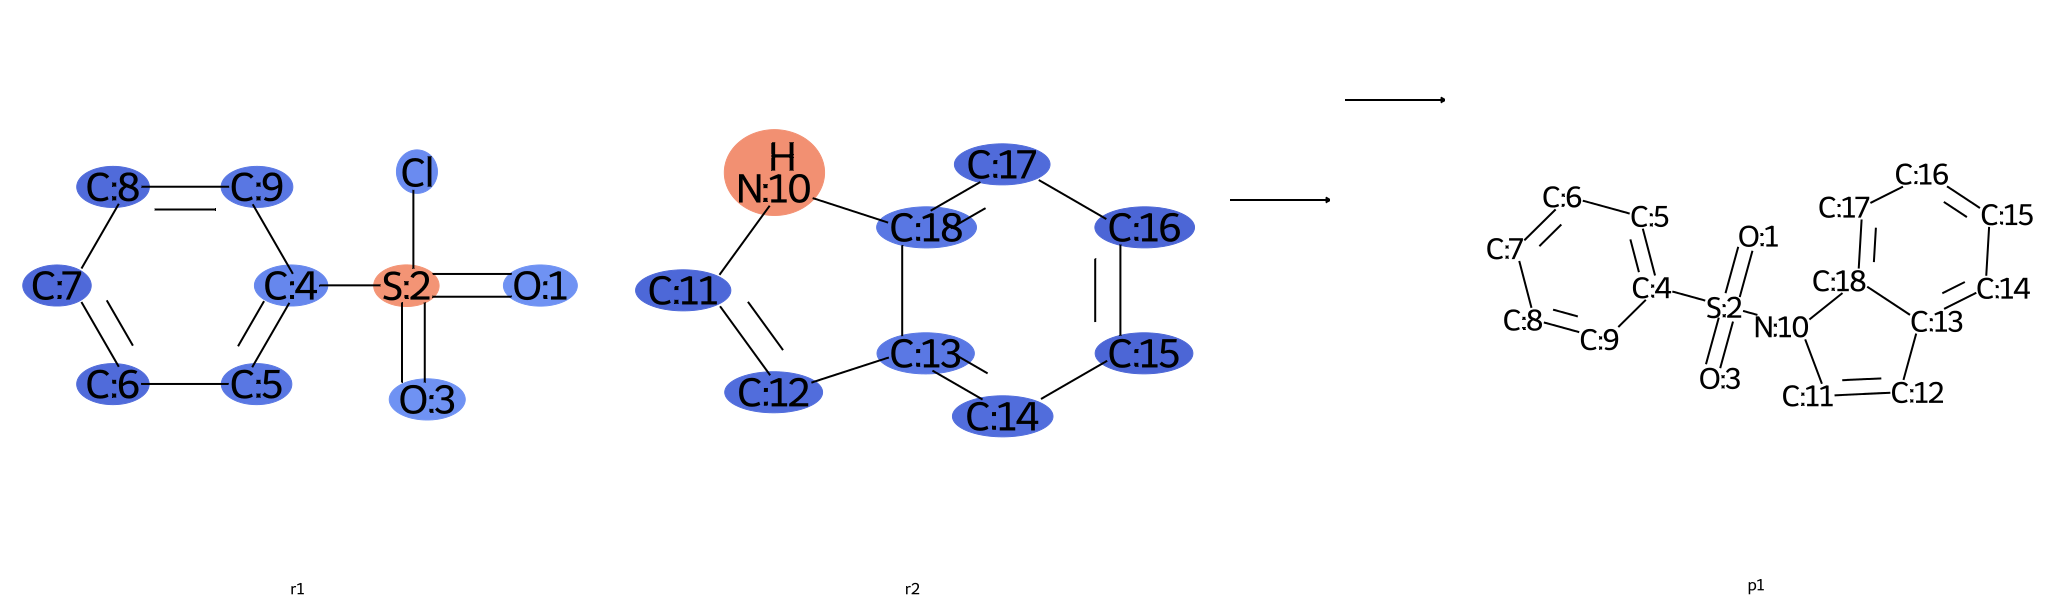

In [117]:
p1 = get_mol(mapped_p1)[0]
d2d = Draw.MolDraw2DCairo(img_size,img_size)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
imgs.append(show_product_mol(d2d,p1,legend='p1'))
print(imgs)
show_images(imgs)

In [21]:
imgs

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x400 at 0x2B284FF33B70>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x400 at 0x2B284FF339B0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x400 at 0x2B27D16A3B70>]

/tmp/ipykernel_38366/648549268.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cool')


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

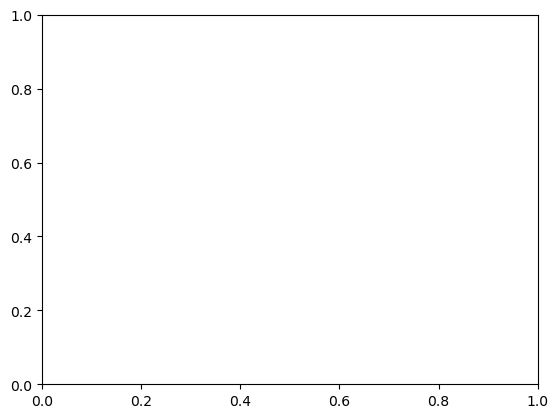

In [158]:
import matplotlib.pyplot as plt
import numpy as np

# Define a colormap ranging from light red to dark red
cmap = plt.cm.get_cmap('cool')

# Create a figure and axis for the colorbar
fig, ax = plt.subplots()

# Set up a ScalarMappable with colormap and normalization
norm = plt.Normalize(vmin=0, vmax=1)  # Example normalization from 0 to 1
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # No actual data is needed

# Add colorbar to the figure
fig.colorbar(sm, orientation='vertical', label='Node weight')

plt.show()